# You Only Look Once: Unified, Real-Time Object Detection

YOLO (You Only Look Once) es un enfoque innovador en el campo de la detección de objetos. A diferencia de los métodos tradicionales, que suelen aplicar la detección en varias etapas, YOLO realiza la detección de objetos en una sola pasada a través de la red neuronal. Esto lo convierte en uno de los detectores de objetos más rápidos y eficientes disponibles.

YOLO ofrece varias ventajas significativas:

* Velocidad: Al procesar la imagen completa en una sola pasada, YOLO puede realizar detecciones en tiempo real.
* Precisión: Aunque inicialmente no era tan preciso como otros métodos, las mejoras en las versiones más recientes han aumentado significativamente su precisión.
* Aprendizaje de Contexto: Al ver toda la imagen durante la detección, YOLO puede aprender contextualmente sobre las clases de objetos, lo que reduce los falsos positivos.

Si bien YOLO es potente, como cualquier modelo, tiene limitaciones. Por ejemplo, puede luchar con objetos muy pequeños o con objetos que aparecen en grupos. Sin embargo, las continuas mejoras y variaciones de la arquitectura YOLO están abordando estas y otras limitaciones, manteniendo a YOLO en la vanguardia de la detección de objetos.

In [1]:
import os
import time

import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm_

import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_pil_image

In [2]:
NUMBER_OF_CLASSES = 20  # Assuming 20 classes from VOC dataset
GRID_SIZE = 7  # Grid size (e.g., 7 x 7)
NUMBER_OF_BBOXES = 2  # Number of bounding boxes per grid cell (e.g., 3)
IMAGE_SIZE = 448

BATCH_SIZE = 64

# Define a mapping for VOC labels to integers
VOC_LABELS = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3,
    'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7,
    'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
    'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15,
    'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

CONF_THRESH = 0.5
IOU_THRESH = 0.65

CLASS_LABELS = list(VOC_LABELS.keys())

## Arquitectura

La arquitectura de YOLO es única y se basa en una red neuronal convolucional profunda. Tradicionalmente, la versión "YOLOv1" emplea una red con 24 capas convolucionales seguidas de 2 capas completamente conectadas. En versiones posteriores, como YOLOv3 y YOLOv4, se introducen mejoras significativas como bloques residuales, conexiones de salto y capas convolucionales de upsampling para mejorar la precisión y el rendimiento. Estas redes están diseñadas para procesar toda la imagen en una sola evaluación, lo que permite detectar objetos en diferentes escalas y aspectos de forma eficiente.

YOLO divide la imagen en una cuadrícula (por ejemplo, 13x13 en YOLOv3) y para cada celda de la cuadrícula, predice múltiples bounding boxes o cajas de contorno, junto con sus puntuaciones de confianza y probabilidades de clase. Cada bounding box contiene cinco predicciones: coordenadas (x, y), ancho, alto, y una puntuación de confianza. La puntuación de confianza refleja qué tan seguro está el modelo de que la caja contiene un objeto y qué tan preciso es el cuadro delimitador.

In [3]:
class ResidualBlock(nn.Module):
    """
    A residual block as used in ResNet, with two convolutional layers and a skip connection.
    """

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip_connection = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip_connection(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity
        out = self.relu(out)
        return out


class TinyYOLO(nn.Module):
    """
     Tiny YOLO model for object detection with increased complexity.
    """

    def __init__(self, num_classes=NUMBER_OF_CLASSES):
        super(TinyYOLO, self).__init__()
        self.num_classes = num_classes

        # Define the layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 224x224
        )

        self.layer2 = self._make_layer(16, 32)  # Output: 112x112
        self.layer3 = self._make_layer(32, 64)  # Output: 56x56
        self.layer4 = self._make_layer(64, 128)  # Output: 28x28
        self.layer5 = self._make_layer(128, 256)  # Output: 14x14
        # No max-pooling here to keep the size 14x14

        # Convolution without spatial reduction
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1)
            # No max-pooling, size remains 14x14
        )

        # Convolution to reduce to 7x7
        self.layer7 = self._make_layer(512, 1024)  # Output: 7x7

        # Output layer
        self.output = nn.Conv2d(
            1024, 5 * NUMBER_OF_BBOXES + num_classes, kernel_size=1)

    def _make_layer(self, in_channels, out_channels):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=2))
        layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.output(x)
        return x

    def detect(self, images, conf_thresh=CONF_THRESH, iou_thresh=IOU_THRESH):
        """
        Detect objects in images.

        Args:
            images (Tensor): Tensor of images, [batch_size, 3, 448, 448].
            conf_thresh (float): Confidence threshold.
            iou_thresh (float): IOU threshold for NMS.

        Returns:
            list: List of lists of size [number of boxes, 7] where the 7 elements are
                [x1, y1, x2, y2, objectness score, class_score, class_id] for each detected bounding box.
        """
        # Get the model outputs
        outputs = self(images)

        # Apply non-maximum suppression
        return non_max_suppression(outputs, conf_thresh, iou_thresh)

## Non maximum suppresion

Non-Maximum Suppression (NMS) es una técnica crucial utilizada en YOLO para asegurar que cada objeto sea detectado solo una vez. Dado que el modelo predice múltiples bounding boxes para cada celda, NMS ayuda a eliminar las cajas redundantes, seleccionando solo las más precisas (aquellas con la mayor puntuación de confianza) y descartando las demás que tienen un alto solapamiento (según IoU) con la caja seleccionada.

In [ ]:
def non_max_suppression(predictions, conf_thresh, iou_thresh):
    """
    Applies Non-Maximum Suppression to filter predictions.

    Args:
        predictions (Tensor): The predictions from the model.
        conf_thresh (float): Confidence threshold.
        iou_thresh (float): IOU threshold for NMS.

    Returns:
        list: List of lists of size [number of boxes, 7] where the 7 elements are
            [x1, y1, x2, y2, objectness score, class_score, class_id] for each detected bounding box.
    """
    nms_predictions = []

    batch_size = predictions.size(0)

    predictions = predictions.view(
        batch_size, NUMBER_OF_BBOXES * 5 + NUMBER_OF_CLASSES, GRID_SIZE, GRID_SIZE).permute(0, 2, 3, 1)

    for image in range(batch_size):
        image_predictions = []

        for y in range(GRID_SIZE):
            for x in range(GRID_SIZE):
                # Last 20 channels for class probabilities
                class_probs = predictions[image, y, x,
                                          5 * NUMBER_OF_BBOXES:]

                # Find the class index with the maximum value
                class_score, class_id = torch.max(class_probs, 0)

                for bbox in range(NUMBER_OF_BBOXES):
                    # Get the 5 + number of classes elements
                    box_data = predictions[image, y, x, bbox *
                                           5: (bbox + 1) * 5 + NUMBER_OF_CLASSES]
                    # Rectify predicted box dimensions
                    x_center, y_center, width, height = nn.ReLU()(box_data[:4])
                    # Sigma function for objectness score
                    objectness = torch.sigmoid(box_data[4])

                    # Filter predictions below the confidence threshold
                    if objectness < conf_thresh:
                        continue

                    # Denormalize coordinates from [0, 1] relative to the grid cell to [0, 448] relative to the image
                    x_center = (x + x_center) * (IMAGE_SIZE / GRID_SIZE)
                    y_center = (y + y_center) * (IMAGE_SIZE / GRID_SIZE)
                    width = width * IMAGE_SIZE
                    height = height * IMAGE_SIZE

                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)

                    # Create a list of [x1, y1, x2, y2, objectness, class_score, class_id]
                    # and append it to the output for this image
                    image_predictions.append(
                        [x1, y1, x2, y2, objectness, class_score, class_id])

        # Sort the predictions by objectness score
        image_predictions = sorted(
            image_predictions, key=lambda x: x[4], reverse=True)

        # Perform non-maximum suppression
        nms_predictions.append(
            non_max_suppression_per_image(image_predictions, iou_thresh))
        # image_predictions)

    return nms_predictions


def non_max_suppression_per_image(image_predictions, iou_thresh):
    """
    Applies Non-Maximum Suppression to filter predictions for a single image.

    Args:
        image_predictions (list): The predictions for a single image.
        iou_thresh (float): IOU threshold for NMS.

    Returns:
        list: List of lists of size [number of boxes, 7] where the 6 elements are
            [x1, y1, x2, y2, objectness score, class_score, class_id] for each detected bounding box.
    """
    # Sort the predictions by objectness score
    image_predictions = sorted(
        image_predictions, key=lambda x: x[4], reverse=True)

    # Perform non-maximum suppression
    nms_predictions = []
    while image_predictions:
        # Pick the bounding box with the highest objectness score
        best_box = image_predictions.pop(0)
        nms_predictions.append(best_box)

        # Find the IoU of all remaining boxes with the best box
        iou = iou_fn(
            best_box[0:4], [box[0:4] for box in image_predictions])

        # Remove the boxes that overlap too much with the best box
        image_predictions = [box for i, box in enumerate(
            image_predictions) if iou[i] < iou_thresh]

    return nms_predictions

## IoU (Intersection over union)

El concepto de Intersección sobre la Unión (IoU) es fundamental en la detección de objetos. IoU es una métrica que mide el solapamiento entre dos bounding boxes, es decir, la caja de contorno predicha y la caja de contorno real (ground truth). Se calcula como el área de la intersección dividida por el área de la unión de estas dos cajas. En YOLO, IoU se utiliza para medir la precisión de las predicciones del modelo.

In [ ]:
def iou_fn(box1, boxes):
    """
    Compute IoU of one box with many boxes.

    Args:
        box1 (List): Single bounding box.
        boxes (List): Multiple bounding boxes.

    Returns:
        Tensor: IoU values.
    """
    # Compute box1's area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])

    # Compute the area of the intersection of box1 with the other boxes
    area_intersection = torch.tensor([intersection_area(box1, box2)
                                      for box2 in boxes])

    # Compute the area of the union of box1 with the other boxes
    area_union = box1_area + torch.tensor([(
        box2[2] - box2[0]) * (box2[3] - box2[1]) for box2 in boxes]) - area_intersection

    # Compute the IoU between box1 and the other
    return area_intersection / area_union


def intersection_area(box1, box2):
    """
    Compute the area of intersection between two bounding boxes.

    Args:
        box1 (List): First bounding box.
        box2 (List): Second bounding box.
    """
    # Compute the intersection of box1 with the other box
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the area of the intersection
    return max(0, x2 - x1) * max(0, y2 - y1)


def bbox_iou(box1, box2):
    """
    Calculate the Intersection Over Union (IOU) of two bounding boxes.

    Parameters:
    box1 (tensor): Predicted bounding box, shape: (..., 4) [x_center, y_center, width, height]
    box2 (tensor): Ground truth box, shape: (..., 4) [x_center, y_center, width, height]

    Returns:
    tensor: IOU
    """
    # Convert bounding boxes from [x_center, y_center, width, height] to [x1, y1, x2, y2]
    box1_x1 = box1[..., 0] - box1[..., 2] / 2
    box1_y1 = box1[..., 1] - box1[..., 3] / 2
    box1_x2 = box1[..., 0] + box1[..., 2] / 2
    box1_y2 = box1[..., 1] + box1[..., 3] / 2

    box2_x1 = box2[..., 0] - box2[..., 2] / 2
    box2_y1 = box2[..., 1] - box2[..., 3] / 2
    box2_x2 = box2[..., 0] + box2[..., 2] / 2
    box2_y2 = box2[..., 1] + box2[..., 3] / 2

    # Get the coordinates of the intersection rectangle
    inter_rect_x1 = torch.max(box1_x1, box2_x1)
    inter_rect_y1 = torch.max(box1_y1, box2_y1)
    inter_rect_x2 = torch.min(box1_x2, box2_x2)
    inter_rect_y2 = torch.min(box1_y2, box2_y2)

    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1, min=0) * \
        torch.clamp(inter_rect_y2 - inter_rect_y1, min=0)

    # Union Area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    # IOU
    union_area = box1_area + box2_area - inter_area
    # Avoid division by zero
    iou = inter_area / torch.clamp(union_area, min=1e-10)

    return iou

## Función de pérdida

La función de pérdida en YOLO es compleja, ya que necesita considerar varios factores: la precisión de las cajas delimitadoras, la confianza del objeto, y la clasificación de las clases. La función de pérdida penaliza errores en la predicción de coordenadas, en la confianza de las cajas que contienen objetos y en la clasificación de estos objetos. Esto garantiza que el modelo se entrene de manera efectiva en todos los aspectos de la detección de objetos.

In [4]:
class YOLOLoss(nn.Module):
    """
    Improved YOLO loss function.
    """

    def __init__(self, lambda_coord, lambda_noobj, lambda_obj, lambda_class):
        super(YOLOLoss, self).__init__()
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.lambda_obj = lambda_obj
        self.lambda_class = lambda_class

    def forward(self, predictions, target):
        # Reshape to GRID_SIZE x GRID_SIZE grid
        pred = predictions.view(-1, NUMBER_OF_BBOXES * 5 + NUMBER_OF_CLASSES,
                                GRID_SIZE, GRID_SIZE).permute(0, 2, 3, 1)
        targ = target.view(-1, NUMBER_OF_BBOXES * 5 + NUMBER_OF_CLASSES,
                           GRID_SIZE, GRID_SIZE).permute(0, 2, 3, 1)

        # Separate components
        pred_boxes = pred[..., :NUMBER_OF_BBOXES * 5].contiguous().view(-1,
                                                                        GRID_SIZE, GRID_SIZE, NUMBER_OF_BBOXES, 5)
        pred_classes = pred[..., NUMBER_OF_BBOXES * 5:]
        # Rectify predicted box dimensions only (x, y, w, h)
        pred_boxes[..., :4] = nn.ReLU()(pred_boxes[..., :4])
        # Apply sigmoid to objectness scores
        pred_boxes[..., 4] = torch.sigmoid(pred_boxes[..., 4])

        targ_boxes = targ[..., :NUMBER_OF_BBOXES * 5].contiguous().view(-1,
                                                                        GRID_SIZE, GRID_SIZE, NUMBER_OF_BBOXES, 5)
        targ_classes = targ[..., NUMBER_OF_BBOXES * 5:]

        # Masks for object/no-object
        obj_mask = targ_boxes[..., 4] > 0
        noobj_mask = targ_boxes[..., 4] == 0

        # Classes have more dimensions so the mask needs to be expanded
        obj_mask_for_classes = obj_mask.any(dim=-1)
        # Now, instead of adding an extra dimension, reshape the mask to match the shape of pred_classes
        obj_mask_for_classes = obj_mask_for_classes.unsqueeze(
            -1).expand(-1, -1, -1, NUMBER_OF_CLASSES)

        # Apply the mask
        masked_pred_classes = pred_classes[obj_mask_for_classes].view(
            -1, NUMBER_OF_CLASSES)
        masked_targ_classes = targ_classes[obj_mask_for_classes].view(
            -1, NUMBER_OF_CLASSES)

        # Box losses
        box_loss = F.mse_loss(
            pred_boxes[obj_mask][..., :2], targ_boxes[obj_mask][..., :2], reduction='sum')

        box_loss += F.mse_loss(torch.sqrt(pred_boxes[obj_mask][..., 2:4]),
                               torch.sqrt(targ_boxes[obj_mask][..., 2:4]), reduction='sum')

        # Objectness loss
        # Calculate IOU for each predicted box with its corresponding ground truth
        ious = bbox_iou(pred_boxes[..., :4], targ_boxes[..., :4])
        # Detach ious from the computation graph as we don't need gradients for them
        ious = ious.detach()

        # Multiply ious by predicted objectiveness
        pred_obj = pred_boxes[..., 4] * ious

        # Modify objectness loss
        obj_loss = F.mse_loss(
            pred_obj[obj_mask], targ_boxes[obj_mask][..., 4], reduction='sum')

        noobj_loss = F.mse_loss(
            pred_obj[noobj_mask], targ_boxes[noobj_mask][..., 4], reduction='sum')

        # Class loss with Focal Loss
        focal_loss = F.binary_cross_entropy_with_logits(
            masked_pred_classes, masked_targ_classes, reduction='none')
        alpha = 0.25
        gamma = 2.0
        focal_loss *= alpha * (1 - torch.exp(-focal_loss)) ** gamma

        class_loss = focal_loss.sum()

        # Combine losses
        loss = self.lambda_coord * box_loss + \
            self.lambda_obj * obj_loss + \
            self.lambda_noobj * noobj_loss + \
            self.lambda_class * class_loss

        # Normalize by batch size
        loss /= predictions.size(0)

        return loss

## mAP

La métrica mAP, que significa "mean Average Precision" (media de la Precisión Promedio), es una de las métricas más importantes en el campo de la detección de objetos. Se utiliza para evaluar el rendimiento de modelos como YOLO. En esencia, la mAP es el promedio de la Precisión Promedio (AP) para cada clase. La AP para una clase específica se calcula basándose en la curva Precisión-Recall (P-R), la cual se obtiene al variar el umbral de decisión para la detección de objetos. En este contexto, la precisión se refiere a qué porcentaje de las detecciones realizadas son correctas, mientras que el recall indica qué porcentaje de los objetos reales fueron correctamente detectados por el modelo. La mAP proporciona una medida integral del rendimiento de un modelo de detección de objetos, teniendo en cuenta tanto la precisión como la exhaustividad (recall) a través de diferentes clases y umbrales. Esta métrica es especialmente valiosa porque considera tanto la capacidad del modelo para identificar correctamente los objetos (evitando falsos negativos) como para evitar clasificar erróneamente los objetos que no están presentes (minimizando los falsos positivos).

In [5]:
def calculate_ap_per_class(tp, conf, pred_cls, target_cls):
    """
    Calculate the average precision, given true positive, confidence, 
    and predicted and target classes.
    """
    # Sort by confidence
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create an AP dictionary
    ap_dict = dict()
    for c in unique_classes:
        # All predictions and targets for this class
        pred_for_class = pred_cls == c
        target_for_class = target_cls == c

        # Compute average precision
        if np.sum(target_for_class) == 0:
            ap_dict[c] = 0.0
            continue

        ap = average_precision_score(target_for_class, conf[pred_for_class])
        ap_dict[c] = ap

    return ap_dict


def calculate_iou(boxes1, boxes2):
    """
    Calculate the Intersection over Union (IoU) of two sets of boxes.

    Args:
        boxes1 (Tensor): bounding boxes, size [N, 4]
        boxes2 (Tensor): bounding boxes, size [M, 4]

    Returns:
        Tensor: IoU values, size [N, M]
    """
    boxes1 = flatten_bboxes(boxes1)
    boxes2 = flatten_bboxes(boxes2)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    inter_x1 = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    inter_y1 = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    inter_x2 = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    inter_y2 = torch.min(boxes1[:, None, 3], boxes2[:, 3])

    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * \
        torch.clamp(inter_y2 - inter_y1, min=0)

    union_area = area1[:, None] + area2 - inter_area

    iou = inter_area / union_area

    return iou


def flatten_bboxes(tensor):
    """
    Flatten a 4D bounding box tensor into a 2D tensor.

    Args:
        tensor (Tensor): A 4D tensor of shape [A, B, C, D].

    Returns:
        Tensor: A 2D tensor of shape [A * C * D, B].
    """
    A, B, C, D = tensor.shape
    # Reshape to [A * C * D, B]
    tensor = tensor.reshape(A, B, C * D).transpose(1, 2).reshape(-1, B)
    return tensor


def match_predictions(iou, iou_thresh):
    """
    Matches predicted bounding boxes with ground truth boxes based on IoU.

    Args:
        iou (Tensor): The IoU values between predictions and ground truths, size [N, M].
        iou_thresh (float): The threshold for IoU to consider a match.

    Returns:
        List[Tuple]: A list of matched pairs (index_pred, index_gt).
    """
    matches = []
    N, M = iou.shape

    # Iterate over each prediction
    for i in range(N):
        # Find the best matching ground truth box
        best_match = -1
        best_iou = iou_thresh

        for j in range(M):
            if iou[i, j] > best_iou:
                best_match = j
                best_iou = iou[i, j]

        if best_match != -1:
            matches.append((i, best_match))

    return matches


def update_metrics(matches, scores, pred_labels, gt_labels):
    """
    Update true positives, false positives, confidences, and class predictions.
    """

    tp = np.zeros(len(scores))
    fp = np.zeros(len(scores))
    for i, match in enumerate(matches):
        if pred_labels[i] == gt_labels[match]:
            tp[i] = 1
        else:
            fp[i] = 1
    return tp, fp, scores, pred_labels

In [6]:
def train_model(model, train_loader, validation_loader, num_epochs=100):
    """
    Main training loop for the model.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device '{device}'.")

    # Define the loss function with the appropriate parameters
    loss_function = YOLOLoss(
        lambda_coord=5, lambda_noobj=0.5, lambda_obj=1, lambda_class=1)
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Define the learning rate scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #    optimizer, 'min', patience=3, factor=0.1)

    # Transfer the model to the GPU
    model.to(device)

    # Initialize lists to track losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0

        # Use tqdm for progress bar
        progress_bar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, targets in progress_bar:
            # Transfer images and targets to the GPU
            images = images.to(device)
            targets = targets.to(device)

            # Zero the gradients on each iteration
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_function(outputs, targets)

            # Backward pass
            loss.backward()

            # Clip gradients to avoid exploding gradients
            clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            # Accumulate the loss
            total_loss += loss.item()

            # Update the progress bar
            progress_bar.set_postfix(train_loss=total_loss / len(train_loader))

        # Calculate the average loss for the epoch
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate the model
        avg_val_loss = validate(
            model, validation_loader, loss_function, device)
        val_losses.append(avg_val_loss)

        # Update the learning rate scheduler
        # scheduler.step(avg_val_loss)

        # Print the loss for the epoch
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Save the model if it has the best validation loss so far
        if epoch == 0 or avg_val_loss < min(val_losses[:-1]):
            torch.save(model.state_dict(), 'model_best.pth')

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


def validate(model, validation_loader, loss_function, device):
    """
    Validation step during training.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    # Initialize tqdm progress bar
    progress_bar = tqdm(validation_loader, desc="Validating", leave=False)

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, targets in progress_bar:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            # Update the progress bar
            progress_bar.set_postfix(
                val_loss=total_loss / len(validation_loader))

    return total_loss / len(validation_loader)


def evaluate_map(model, test_loader, iou_thresh=IOU_THRESH, conf_thresh=CONF_THRESH):
    """
    Evaluate the model on the test set and calculate the mAP.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()

    # Lists to store true positives, confidences, and class predictions
    all_tp = []
    all_conf = []
    all_pred_cls = []
    all_target_cls = []

    with torch.no_grad():
        # show progress bar
        progress_bar = tqdm(test_loader, desc="Evaluating", leave=False)

        for images, targets in progress_bar:
            images = images.to(device)

            # Get model predictions
            predictions = model.detect(
                images, conf_thresh=conf_thresh, iou_thresh=iou_thresh)

            batch_size = images.size(0)

            target_tensor = targets.view(
                batch_size, NUMBER_OF_BBOXES * 5 + NUMBER_OF_CLASSES, GRID_SIZE, GRID_SIZE).permute(1, 2, 3, 0).contiguous()

            # Iterate over each image in the batch
            for idx, detections in enumerate(predictions):
                # Get ground truth boxes and labels for the current image
                gt_boxes = detections[:4, :, :].contiguous().view(-1, 4)
                gt_labels = torch.nonzero(
                    detections[4, :, :]).squeeze(1).cpu().numpy()

                # If no boxes are detected, skip the current image
                if detections is None:
                    continue

                # Split detections into boxes, scores, and class labels
                pred_boxes = detections[:, :4]
                scores = detections[:, 4]
                pred_labels = detections[:, 5]

                # Calculate IoU between each predicted box and ground truth box
                iou = calculate_iou(pred_boxes, gt_boxes)
                matches = match_predictions(iou, iou_thresh)

                # Determine which predicted boxes match with which ground truth boxes
                matches = match_predictions(iou, iou_thresh)

                # Update true positives, false positives, confidences, and class predictions
                tp, fp, conf, pred_cls = update_metrics(
                    matches, scores, pred_labels, gt_labels)

                all_tp.append(tp)
                all_conf.append(conf)
                all_pred_cls.append(pred_cls)
                # Note: extend since gt_labels is not batched
                all_target_cls.extend(gt_labels)

    # Concatenate all results
    all_tp = np.concatenate(all_tp)
    all_conf = np.concatenate(all_conf)
    all_pred_cls = np.concatenate(all_pred_cls)
    all_target_cls = np.concatenate(all_target_cls)

    # Calculate AP per class
    ap_per_class = calculate_ap_per_class(
        all_tp, all_conf, all_pred_cls, all_target_cls)

    # Calculate the mean AP across all classes
    mean_ap = np.mean(list(ap_per_class.values()))

    # Print the results
    print(f"Mean Average Precision: {mean_ap:.4f}")
    for cls, ap in ap_per_class.items():
        print(f"AP for class {cls}: {ap:.4f}")

    return mean_ap

In [7]:
def adjust_bounding_box(target: dict):
    """
    Adjusts the bounding box coordinates from the original image size to the resized image size.

    Args:
        target: dict, containing the annotations including the bounding box coordinates and original image size

    Returns:
        x_min_array: list, containing the adjusted x_min coordinates
        y_min_array: list, containing the adjusted y_min coordinates
        x_max_array: list, containing the adjusted x_max coordinates
        y_max_array: list, containing the adjusted y_max coordinates
        names: list, containing the object names
    """
    # Extract original dimensions
    orig_width = int(target['annotation']['size']['width'])
    orig_height = int(target['annotation']['size']['height'])
    # Extract resized dimensions
    resize_width, resize_height = IMAGE_SIZE, IMAGE_SIZE

    # Calculate scale factors
    x_scale = resize_width / orig_width
    y_scale = resize_height / orig_height

    x_min_array, y_min_array, x_max_array, y_max_array = [], [], [], []
    names = []
    # Iterate over each bounding box
    for obj in target['annotation']['object']:
        bbox = obj['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])

        # Adjust bounding box coordinates
        adjusted_xmin = int(xmin * x_scale)
        adjusted_ymin = int(ymin * y_scale)
        adjusted_xmax = int(xmax * x_scale)
        adjusted_ymax = int(ymax * y_scale)

        x_min_array.append(adjusted_xmin)
        y_min_array.append(adjusted_ymin)
        x_max_array.append(adjusted_xmax)
        y_max_array.append(adjusted_ymax)
        names.append(obj['name'])

    return x_min_array, y_min_array, x_max_array, y_max_array, names

In [8]:
def collate_fn(batch):
    """
    Custom collate function for the data loader that handles multiple objects in the same grid cell
    without overwriting bounding boxes.
    """
    images = []
    targets = []

    grid_size = GRID_SIZE
    num_boxes = NUMBER_OF_BBOXES
    num_classes = NUMBER_OF_CLASSES
    image_size = IMAGE_SIZE  # Assuming a square image

    for img, target in batch:
        images.append(img)
        target_tensor = torch.zeros(
            [num_boxes * 5 + num_classes, grid_size, grid_size])

        x_min_array, y_min_array, x_max_array, y_max_array, names = adjust_bounding_box(
            target)

        # Track which boxes have been filled in each cell
        filled_boxes = torch.zeros(
            (grid_size, grid_size, num_boxes), dtype=torch.int64)

        for idx in range(len(x_min_array)):
            xmin = float(x_min_array[idx])
            ymin = float(y_min_array[idx])
            xmax = float(x_max_array[idx])
            ymax = float(y_max_array[idx])

            # Normalize coordinates to [0, 1]
            x_center = ((xmin + xmax) / 2) / image_size
            y_center = ((ymin + ymax) / 2) / image_size

            # Determine grid cell indices
            grid_x = int(x_center * grid_size)
            grid_y = int(y_center * grid_size)

            # X and Y coordinates relative to the grid cell
            x_coord = x_center * grid_size - grid_x
            y_coord = y_center * grid_size - grid_y

            # Width and height relative to the image size
            width = (xmax - xmin) / image_size
            height = (ymax - ymin) / image_size

            # Class label
            label_index = VOC_LABELS[names[idx]]

            # Box coordinates relative to the grid cell
            box_coordinates = torch.tensor(
                [x_coord, y_coord, width, height])

            # Assign to the first available bounding box in this cell
            for b in range(num_boxes):
                if filled_boxes[grid_y, grid_x, b] == 0:
                    box_index = b * 5  # 5 parameters per box
                    target_tensor[box_index:box_index + 4,
                                  grid_y, grid_x] = box_coordinates
                    target_tensor[box_index + 4, grid_y,
                                  grid_x] = 1  # Objectness score
                    filled_boxes[grid_y, grid_x, b] += 1
                    break

            # Shared class probabilities for this grid cell
            # Reset class probabilities
            target_tensor[num_boxes * 5:, grid_y, grid_x] = 0
            target_tensor[num_boxes * 5 + label_index,
                          grid_y, grid_x] = 1  # Set class probability

        targets.append(target_tensor)

    images = torch.stack(images)
    targets = torch.stack(targets)

    return images, targets

In [9]:
def get_datasets():
    """
    Download and load the VOC dataset.
    """
    transform = transforms.Compose([
        # Resize to match YOLO input
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    # Download and load the training and validation sets
    download = not os.path.isdir(
        './data/VOCdevkit/VOC2012')

    train_dataset = VOCDetection(
        root='./data', year='2012', image_set='train', download=download, transform=transform)
    val_dataset = VOCDetection(root='./data', year='2012',
                               image_set='trainval', download=download, transform=transform)
    test_dataset = VOCDetection(root='./data', year='2012',
                                image_set='val', download=download, transform=transform)

    return train_dataset, val_dataset, test_dataset


def get_data_loaders(train_dataset, val_dataset, test_dataset):
    """
    Create data loaders for the training, validation, and test sets.
    """
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=4, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=4, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

In [10]:
def visualize_dataset_sample(dataset, index):
    """
    Visualizes an image and its annotated bounding boxes from the dataset.

    Args:
    - dataset: the VOC dataset object
    - index: the index of the sample to visualize
    """
    # Retrieve the image and target from the dataset
    img, target = dataset[index]

    # Denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    img = to_pil_image(img)  # Convert tensor image to PIL
    # Create a figure and axis for plotting
    _, ax = plt.subplots(1)
    ax.imshow(img)

    x_min_array, y_min_array, x_max_array, y_max_array, names = adjust_bounding_box(
        target)

    # Draw the bounding boxes on the image
    for i in range(len(x_min_array)):
        xmin = int(x_min_array[i])
        ymin = int(y_min_array[i])
        xmax = int(x_max_array[i])
        ymax = int(y_max_array[i])

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add the label
        plt.text(xmin, ymin, names[i], color='white', fontsize=8, bbox=dict(
            facecolor='red', edgecolor='none', pad=1))

    plt.show()

In [11]:
def visualize_collated_sample(image, target_tensor):
    """
    Visualizes an image and its bounding boxes after being processed by the collate_fn.

    Args:
    - image: the image tensor
    - target_tensor: the target tensor in the YOLO format from the collate_fn
    """
    # make a copy of the image tensor
    image = image.clone()

    # Denormalize
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    # Convert the image tensor to a PIL image for visualizatiaoen
    img = to_pil_image(image)

    # Create a figure and axis for plotting
    _, ax = plt.subplots(1)
    ax.imshow(img)

    target_tensor = target_tensor.view(
        NUMBER_OF_BBOXES * 5 + NUMBER_OF_CLASSES, GRID_SIZE, GRID_SIZE).permute(1, 2, 0).contiguous()

    # Draw the bounding boxes on the image
    for y in range(GRID_SIZE):
        for x in range(GRID_SIZE):
            cls_data = target_tensor[y, x, NUMBER_OF_BBOXES * 5:]
            # Get the class name:
            class_label = torch.argmax(cls_data)
            class_name = list(VOC_LABELS.keys())[list(
                VOC_LABELS.values()).index(int(class_label.item()))]

            for bbox in range(NUMBER_OF_BBOXES):
                # Get the 5 + number of classes elements
                box_data = target_tensor[y, x, bbox *
                                         5: (bbox + 1) * 5 + NUMBER_OF_CLASSES]
                # First 4 elements are offsets, last is objectness score
                x_center, y_center, width, height, objectness = box_data[:5]
                objectness = box_data[4]

                if objectness < 0.5:  # Threshold for visualization
                    continue

                # Denormalize coordinates from [0, 1] relative to the grid cell to [0, 448] relative to the image
                x_center = (x + x_center) * (IMAGE_SIZE / GRID_SIZE)
                y_center = (y + y_center) * (IMAGE_SIZE / GRID_SIZE)
                width = width * IMAGE_SIZE
                height = height * IMAGE_SIZE

                # Convert to xmin, ymin, xmax, ymax
                xmin = x_center - width / 2
                ymin = y_center - height / 2
                xmax = x_center + width / 2
                ymax = y_center + height / 2

                # Create a Rectangle patch
                rect = patches.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    linewidth=1,
                    edgecolor='r',
                    facecolor='none'
                )

                # Add the patch to the Axes
                ax.add_patch(rect)

                plt.text(
                    xmin,
                    ymin,
                    class_name,
                    color='white',
                    fontsize=8,
                    bbox=dict(facecolor='red', edgecolor='none', pad=1)
                )

    plt.show()

In [12]:
def get_model(weights=None, train_loader=None, val_loader=None, force_train=False):
    """
    Load model weights from disk if they exist, otherwise train the model.

    Args:
        weights (str): Path to the model weights.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.

    Returns:
        TinyYOLO: The model.
    """
    model = TinyYOLO(num_classes=NUMBER_OF_CLASSES)

    if weights is not None and os.path.exists(weights):
        print(f'Loading weights from {weights}')
        model.load_state_dict(torch.load(weights))
        if not force_train:
            return model

    model = train_model(model, train_loader, val_loader)
    # Save model with the timestamp
    model_name = f'model_{int(time.time())}.pth'
    torch.save(model.state_dict(), model_name)
    print(f'Saved model as {model_name}')

    return model

In [13]:
def plot_bounding_boxes(images: torch.Tensor, nms_predictions: list, class_labels: list, confidence_threshold=CONF_THRESH):
    """
    Plots bounding boxes on images.

    Args:
        images (Tensor): List of images.
        nms_predictions (list of Tensors): Bounding boxes after NMS, one tensor per image.
        class_labels (list of str): List of class labels.
        confidence_threshold (float): Threshold to filter boxes with low confidence.
    """
    batch_size = len(nms_predictions)

    # Send to cpu
    images = images.cpu()

    # Denormalize images
    images = images * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    for i in range(batch_size):
        _, ax = plt.subplots(1, figsize=(12, 9))
        img = to_pil_image(images[i])
        ax.imshow(img)

        if len(nms_predictions[i]) == 0:
            continue

        prediction = nms_predictions[i]

        for bbox in prediction:
            x1, y1, x2, y2, objectness, class_score, class_id = bbox

            if class_score < confidence_threshold:
                continue

            # Create a Rectangle patch
            rect = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add text (class label and confidence)
            label = f'{class_labels[int(class_id)]}: {class_score:.2f}'
            ax.text(x1, y1, label, color='white',
                    backgroundcolor='red', fontsize=8, clip_on=True)

        plt.show()

In [14]:
train_dataset, val_dataset, test_dataset = get_datasets()

In [15]:
train_loader, val_loader, test_loader = get_data_loaders(
    train_dataset, val_dataset, test_dataset)

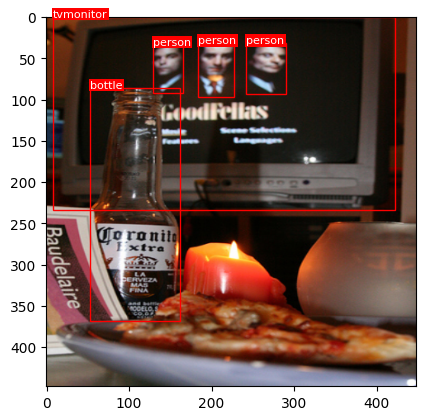

In [16]:
# Visualize a sample from the dataset
index = 9
visualize_dataset_sample(val_dataset, index)

In [17]:
# Visualize a sample from the collated dataset
images, targets = next(iter(val_loader))

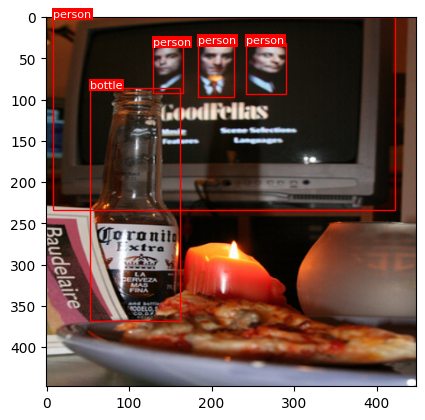

In [18]:
visualize_collated_sample(
    images[index],
    targets[index])

In [19]:
# List model_*.pth files in the current directory
# and sort them by name, get the last one and load it
weights = None
if len(os.listdir('.')) > 0:
    weights = sorted([f for f in os.listdir(
        '.') if f.startswith('model_')], reverse=True)[0]

Loading weights from model_best.pth
Training on device 'cuda'.


Epoch [1/100], Train Loss: 9.0058, Validation Loss: 10.1820


Epoch [2/100], Train Loss: 8.6059, Validation Loss: 9.8822


Epoch [3/100], Train Loss: 8.2339, Validation Loss: 9.8556


Epoch [4/100], Train Loss: 7.8355, Validation Loss: 9.4317


Epoch [5/100], Train Loss: 7.5724, Validation Loss: 9.3204


Epoch [6/100], Train Loss: 7.2174, Validation Loss: 9.1401


Epoch [7/100], Train Loss: 6.9679, Validation Loss: 8.9316


Epoch [8/100], Train Loss: 6.7277, Validation Loss: 8.9131


Epoch [9/100], Train Loss: 6.4663, Validation Loss: 8.5542


Epoch [10/100], Train Loss: 6.2027, Validation Loss: 8.4816


Epoch [11/100], Train Loss: 6.0307, Validation Loss: 8.2160


Epoch [12/100], Train Loss: 5.8639, Validation Loss: 8.1246


Epoch [13/100], Train Loss: 5.6656, Validation Loss: 7.9415


Epoch [14/100], Train Loss: 5.5806, Validation Loss: 8.1269


Epoch [15/100], Train Loss: 5.3531, Validation Loss: 7.7886


Epoch [16/100], Train Loss: 5.2993, Validation Loss: 7.6008


Epoch [17/100], Train Loss: 5.1303, Validation Loss: 7.6499


Epoch [18/100], Train Loss: 5.0560, Validation Loss: 7.4800


Epoch [19/100], Train Loss: 4.9134, Validation Loss: 7.2222


Epoch [20/100], Train Loss: 4.8974, Validation Loss: 7.2228


Epoch [21/100], Train Loss: 4.7201, Validation Loss: 7.2193


Epoch [22/100], Train Loss: 4.5999, Validation Loss: 7.0796


Epoch [23/100], Train Loss: 4.5276, Validation Loss: 7.1034


Epoch [24/100], Train Loss: 4.4566, Validation Loss: 6.9522


Epoch [25/100], Train Loss: 4.3729, Validation Loss: 6.8254


Epoch [26/100], Train Loss: 4.3705, Validation Loss: 6.8876


Epoch [27/100], Train Loss: 4.2193, Validation Loss: 6.7668


Epoch [28/100], Train Loss: 4.1372, Validation Loss: 6.6056


Epoch [29/100], Train Loss: 4.1245, Validation Loss: 6.6049


Epoch [30/100], Train Loss: 3.9812, Validation Loss: 6.5140


Epoch [31/100], Train Loss: 3.9503, Validation Loss: 6.4888


Epoch [32/100], Train Loss: 3.9167, Validation Loss: 6.4598


Epoch [33/100], Train Loss: 3.8136, Validation Loss: 6.4184


Epoch [34/100], Train Loss: 3.7968, Validation Loss: 6.4160


Epoch [35/100], Train Loss: 3.6641, Validation Loss: 6.3013


Epoch [36/100], Train Loss: 3.7481, Validation Loss: 6.1691


Epoch [37/100], Train Loss: 3.6940, Validation Loss: 6.3139


Epoch [38/100], Train Loss: 3.6253, Validation Loss: 6.1353


Epoch [39/100], Train Loss: 3.4845, Validation Loss: 6.1491


Epoch [40/100], Train Loss: 3.4633, Validation Loss: 6.0073


Epoch [41/100], Train Loss: 3.4433, Validation Loss: 6.1259


Epoch [42/100], Train Loss: 3.4199, Validation Loss: 5.9944


Epoch [43/100], Train Loss: 3.3530, Validation Loss: 6.0001


Epoch [44/100], Train Loss: 3.4200, Validation Loss: 6.0873


Epoch [45/100], Train Loss: 3.2699, Validation Loss: 5.9021


Epoch [46/100], Train Loss: 3.2213, Validation Loss: 5.9290


Epoch [47/100], Train Loss: 3.2346, Validation Loss: 5.9884


Epoch [48/100], Train Loss: 3.1800, Validation Loss: 5.8770


Epoch [49/100], Train Loss: 3.2005, Validation Loss: 5.8409


Epoch [50/100], Train Loss: 3.1838, Validation Loss: 5.8324


Epoch [51/100], Train Loss: 3.1611, Validation Loss: 5.7490


Epoch [52/100], Train Loss: 3.0473, Validation Loss: 5.7346


Epoch [53/100], Train Loss: 3.0298, Validation Loss: 5.6017


Epoch [54/100], Train Loss: 3.0431, Validation Loss: 5.6260


Epoch [55/100], Train Loss: 2.9734, Validation Loss: 5.5579


Epoch [56/100], Train Loss: 2.9891, Validation Loss: 5.5812


Epoch [57/100], Train Loss: 2.8929, Validation Loss: 5.6304


Epoch [58/100], Train Loss: 2.8766, Validation Loss: 5.5071


Epoch [59/100], Train Loss: 2.8542, Validation Loss: 5.5942


Epoch [60/100], Train Loss: 2.8428, Validation Loss: 5.4961


Epoch [61/100], Train Loss: 2.8603, Validation Loss: 5.4683


Epoch [62/100], Train Loss: 2.8008, Validation Loss: 5.4052


Epoch [63/100], Train Loss: 2.7302, Validation Loss: 5.3723


Epoch [64/100], Train Loss: 2.8029, Validation Loss: 5.4054


Epoch [65/100], Train Loss: 2.7281, Validation Loss: 5.4251


Epoch [66/100], Train Loss: 2.7471, Validation Loss: 5.4205


Epoch [67/100], Train Loss: 2.7282, Validation Loss: 5.3974


Epoch [68/100], Train Loss: 2.6548, Validation Loss: 5.2407


Epoch [69/100], Train Loss: 2.6164, Validation Loss: 5.3094


Epoch [70/100], Train Loss: 2.6653, Validation Loss: 5.3225


Epoch [71/100], Train Loss: 2.6110, Validation Loss: 5.2141


Epoch [72/100], Train Loss: 2.5753, Validation Loss: 5.2563


Epoch [73/100], Train Loss: 2.5571, Validation Loss: 5.2736


Epoch [74/100], Train Loss: 2.5348, Validation Loss: 5.1364


Epoch [75/100], Train Loss: 2.5207, Validation Loss: 5.1206


Epoch [76/100], Train Loss: 2.5161, Validation Loss: 5.1160


Epoch [77/100], Train Loss: 2.5113, Validation Loss: 5.1556


Epoch [78/100], Train Loss: 2.4787, Validation Loss: 5.1599


Epoch [79/100], Train Loss: 2.4576, Validation Loss: 5.1702


Epoch [80/100], Train Loss: 2.4203, Validation Loss: 4.9827


Epoch [81/100], Train Loss: 2.4464, Validation Loss: 4.9970


Epoch [82/100], Train Loss: 2.3804, Validation Loss: 4.9794


Epoch [83/100], Train Loss: 2.3418, Validation Loss: 5.0245


Epoch [84/100], Train Loss: 2.3585, Validation Loss: 4.9851


Epoch [85/100], Train Loss: 2.3954, Validation Loss: 4.9405


Epoch [86/100], Train Loss: 2.3454, Validation Loss: 5.0114


Epoch [87/100], Train Loss: 2.3484, Validation Loss: 4.8927


Epoch [88/100], Train Loss: 2.3148, Validation Loss: 4.8706


Epoch [89/100], Train Loss: 2.3132, Validation Loss: 4.8998


Epoch [90/100], Train Loss: 2.2802, Validation Loss: 4.9177


Epoch [91/100], Train Loss: 2.2614, Validation Loss: 4.8151


Epoch [92/100], Train Loss: 2.2363, Validation Loss: 4.7899


Epoch [93/100], Train Loss: 2.2287, Validation Loss: 4.8766


Epoch [94/100], Train Loss: 2.2585, Validation Loss: 4.8251


Epoch [95/100], Train Loss: 2.2050, Validation Loss: 4.8304


Epoch [96/100], Train Loss: 2.1821, Validation Loss: 4.8010


Epoch [97/100], Train Loss: 2.1824, Validation Loss: 4.7757


Epoch [98/100], Train Loss: 2.2320, Validation Loss: 4.8183


Epoch [99/100], Train Loss: 2.1742, Validation Loss: 4.8328


Epoch [100/100], Train Loss: 2.1533, Validation Loss: 4.7851


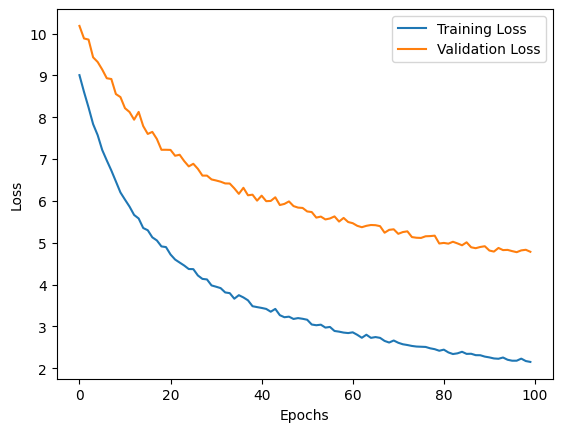

Saved model as model_1700522383.pth


In [20]:
# Get or train the model
# weights = None  # Do not load weights
model = get_model(weights, train_loader, val_loader, True) # Force train
# model = get_model(weights, train_loader, val_loader) # Do not force train

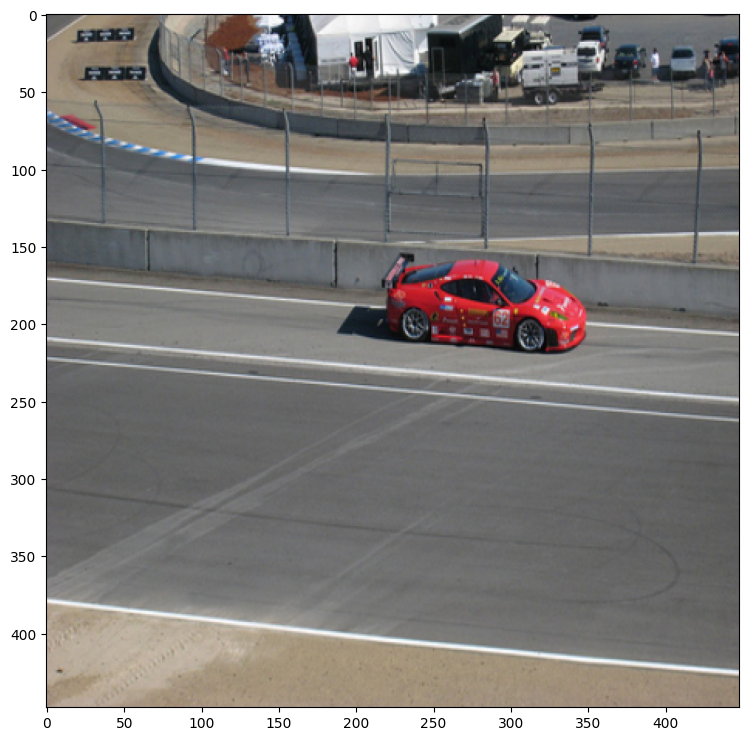

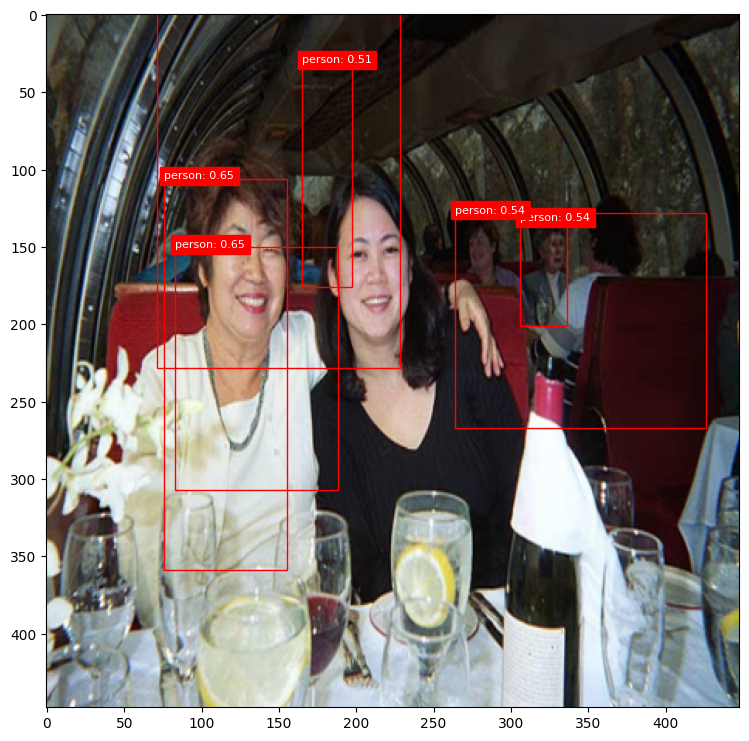

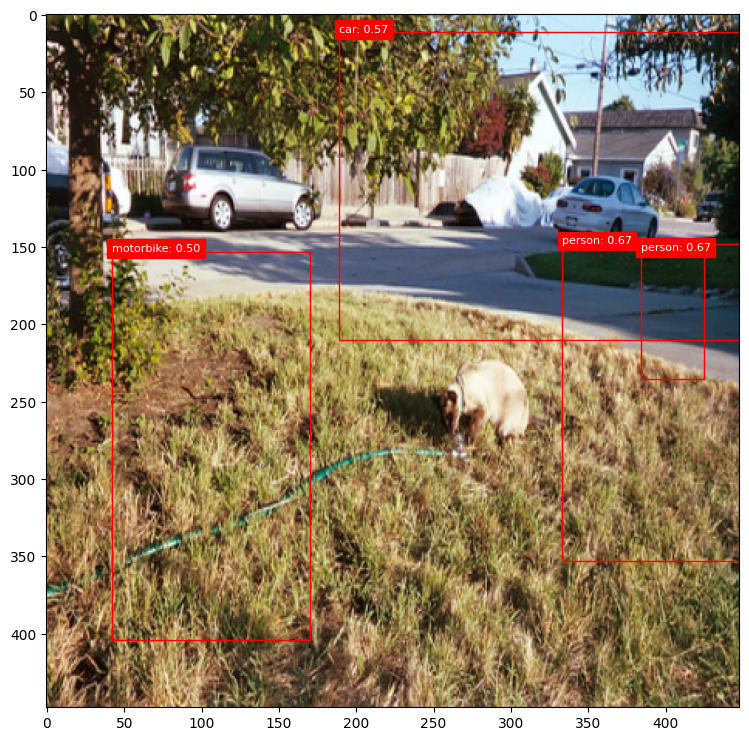

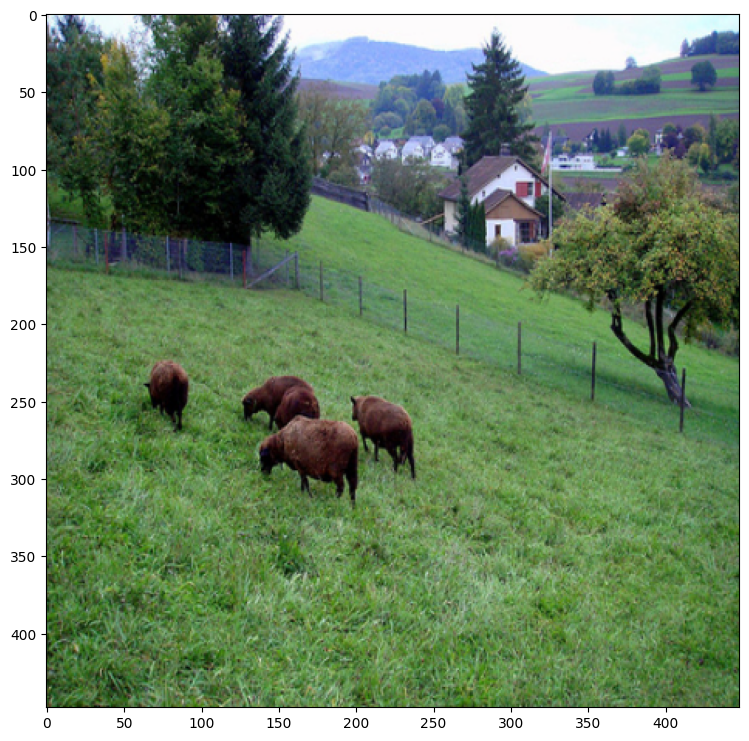

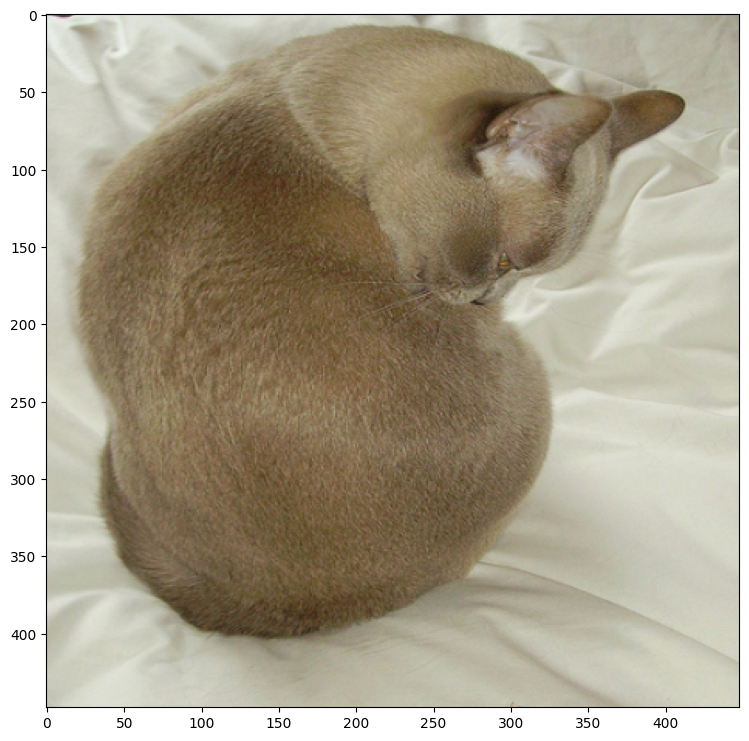

Image 1
Class label: 6, Class name: car
Box data: tensor([0.4219, 0.9219, 0.2946, 0.1429, 1.0000])
Image 2
Class label: 14, Class name: person
Box data: tensor([0.6406, 0.2812, 0.0491, 0.1250, 1.0000])
Class label: 14, Class name: person
Box data: tensor([0.8984, 0.3359, 0.0379, 0.0692, 1.0000])
Class label: 14, Class name: person
Box data: tensor([0.5234, 0.4219, 0.0826, 0.1116, 1.0000])
Class label: 14, Class name: person
Box data: tensor([0.1641, 0.1953, 0.0379, 0.0871, 1.0000])
Class label: 14, Class name: person
Box data: tensor([0.0781, 0.5781, 0.0759, 0.1518, 1.0000])
Class label: 14, Class name: person
Box data: tensor([0.4531, 0.9219, 0.1652, 0.3080, 1.0000])
Class label: 14, Class name: person
Box data: tensor([0.7656, 0.5938, 0.2857, 0.6607, 1.0000])
Class label: 14, Class name: person
Box data: tensor([0.7422, 0.6562, 0.3237, 0.6161, 1.0000])
Class label: 4, Class name: bottle
Box data: tensor([0.0000, 0.2266, 0.1161, 0.5067, 1.0000])
Class label: 10, Class name: diningtabl

In [21]:
model.eval()
num_samples = 5
class_labels = list(VOC_LABELS.keys())

for images, targets in train_loader:
    # Select a few samples
    selected_images = images[:num_samples]

    # Move images to the same device as your model
    selected_images = selected_images.to(next(model.parameters()).device)

    # Run predictions
    with torch.no_grad():
        predictions = model.detect(selected_images)

    # Plot bounding boxes on images
    plot_bounding_boxes(selected_images, predictions, class_labels)

    # Print the correct labels
    targets = targets.view(-1, NUMBER_OF_BBOXES * 5 + NUMBER_OF_CLASSES,
                           GRID_SIZE, GRID_SIZE).permute(0, 2, 3, 1).contiguous()

    for i in range(num_samples):
        print(f'Image {i + 1}')
        for y in range(GRID_SIZE):
            for x in range(GRID_SIZE):
                cls_data = targets[i, y, x, NUMBER_OF_BBOXES * 5:]
                class_label = torch.argmax(cls_data)
                class_name = list(VOC_LABELS.keys())[list(
                    VOC_LABELS.values()).index(int(class_label.item()))]
                for b in range(NUMBER_OF_BBOXES):
                    box_data = targets[i, y, x, b * 5: (b + 1) * 5]
                    objectness = box_data[4]
                    if objectness > 0.5:
                        print(
                            f'Class label: {class_label}, Class name: {class_name}')
                        print(f'Box data: {box_data}')

    break  # Only take the first batch

## Referencias

J. Redmon, S. Divvala, R. Girshick and A. Farhadi, "You Only Look Once: Unified, Real-Time Object Detection," in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016 pp. 779-788.

Terven, Juan & Cordova-Esparza, Diana-Margarita. (2023). A Comprehensive Review of YOLO: From YOLOv1 to YOLOv8 and Beyond. 